#### Define the used fields from the UK biobank, and extract the patients diagnosed with vascular dementia

In [1]:
UKBB_PATH = "~/biobank/ukb672220.csv"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFields import DataFields

# A dictionary containing the used features
datafields = DataFields

# Features of conditions specified by date
DateReportedFields = [
    "Primary Hypertension",
    "Secondary Hypertension",
    "Report of stroke",
    "Stress Reported",
    "Seropositive Rheumatoid Arthritis",
    "Other Rheumatoid Arthritis",
    "Juvenile Arthritis",
    "Other Arthritis",
    "Psoriatic and enteropathic arthropathies",
    "Multiple Sclerosis",
    "Crohn's disease",
    "Ulcerative Colitis",
    "Thyrotoxicosis (Grave's disease)",
    "Sjogren Disease (M35)",
    "Myasthenia gravis",
    "Diagnosed with Coeliac disease",
    "B12 deficiency anaemia"
]

In [2]:
# Read the chunk and get columns from the datafields dictionary
# if Oldest=True, take the oldest instance, otherwise newest
def get_columns_from_chunk(chunk, datafields, oldest=False):
    selected_columns = {}
    for field_name, instances in datafields.items():
        instance_key = min(instances) if oldest else max(instances)
        selected_columns[field_name] = instances[instance_key]
    
    # Select only the necessary columns from the chunk
    filtered_chunk = chunk[list(selected_columns.values())].rename(columns={
        v: k for k, v in selected_columns.items()
    })
    
    return filtered_chunk
    

In [3]:
# Filter by rows to extract patients with vascular dementia
def filter_by_vascular_dementia(chunk):
    col_1_filter = "Vascular Dementia Date First Reported"
    col_2_filter = "Date of vascular dementia report"
    col_combined = "Vascular Dementia Report Date"
    Y_col = "Has Vascular Dementia"
    
    # Filter rows where either col_1_filter or col_2_filter is not NaN
    filtered_chunk = chunk[chunk[col_1_filter].notna() | chunk[col_2_filter].notna()].copy()  # Make a copy here
    
    # Combine dates and add the new columns
    filtered_chunk.loc[:, col_combined] = pd.to_datetime(
        filtered_chunk[col_1_filter].combine_first(filtered_chunk[col_2_filter]), errors="coerce"
    )
    
    # Filter by dates to remove unspecified entries
    filtered_chunk.loc[:, Y_col] = (
        filtered_chunk[col_combined]
        .between(pd.Timestamp("1950-01-01"), pd.Timestamp("2030-12-31"))
        .astype(int)
    )

    return filtered_chunk


In [4]:
# from the given "fields" list, convert all columns where date is in range, to 0 or 1 instead of a date.
# Having date as not NA implies a person was diagnosed with said condition
def convert_date_to_binary(chunk, fields):
    start_date = pd.Timestamp("1950-01-01")
    end_date = pd.Timestamp("2030-01-01")
    
    for col in fields:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
            mask = (df[col] >= start_date) & (df[col] <= end_date)
    
            df[col] = np.where(mask, 1, 0)
    
    return df

### Extract rows diagnosed with vascular dementia through the use of two fields

In [ ]:

chunk_size = 10000

# Create an empty DataFrame to hold the filtered data
result_df = pd.DataFrame()

for chunk in pd.read_csv(UKBB_PATH, chunksize=chunk_size, low_memory=False):

    filtered_chunk = get_columns_from_chunk(chunk, datafields, oldest=True)

    filtered_chunk = filter_by_vascular_dementia(filtered_chunk)
    
    # Append to the result DataFrame
    result_df = pd.concat([result_df, filtered_chunk], ignore_index=True)

# Save the result
result_df.to_csv('vascular_dementia_filtered.csv')

# Display the first 5 rows
result_df.head(5)

### Post process dataframe by converting date data into boolean data

In [5]:
### Save dataframe as csv, to manually observe the data
df = pd.read_csv("vascular_dementia_filtered.csv")

# convert field which use write date a disease is reported and mark it as true or false
# to determine if a person was diagnosed with the diseas or not rather than when.

df = convert_date_to_binary(df, DateReportedFields)

#### Measure the distribution of age, education, and ethnicity of patients diagnosed with vascular dementia (or all columns)

Counts [402 778 504 287 108  72  15   8   7   5]
Edges: [1936.  1939.2 1942.4 1945.6 1948.8 1952.  1955.2 1958.4 1961.6 1964.8
 1968. ]


,Unnamed: 0,id,Birth Year,Sex,Ethnicity,Education,Primary Hypertension,Secondary Hypertension,BMI Impedance,Smoking Status,...,Platelet distribution width,Red blood cell (erythrocyte) count,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Reticulocyte percentage,White blood cell (leukocyte) count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure,Has Vascular Dementia
count,2186.000000,2.186000e+03,2186.000000,2186.000000,2181.000000,2137.000000,2186.000000,2186.000000,2162.000000,2181.000000,...,2037.000000,2037.000000,2037.000000,2005.000000,2005.000000,2037.000000,1983.000000,1983.000000,1983.000000,2186.0
mean,1092.500000,3.515518e+06,1943.111162,0.582342,1072.196240,-1.001404,0.789113,0.002745,28.557839,0.658414,...,16.542081,4.489278,13.725449,0.064314,1.435638,7.335621,81.993444,147.228946,70.938477,1.0
std,631.188165,1.442844e+06,4.317173,0.493286,468.249479,4.960943,0.408032,0.052330,5.139395,0.769999,...,0.531861,0.444468,1.094076,0.035324,0.804452,1.956365,11.199929,21.110899,13.162657,0.0
min,0.000000,1.002012e+06,1936.000000,0.000000,-3.000000,-7.000000,0.000000,0.000000,15.757600,-3.000000,...,15.200000,1.720000,11.490000,0.012000,0.263000,2.370000,47.000000,78.000000,35.000000,1.0
25%,546.250000,2.300567e+06,1940.000000,0.000000,1001.000000,-7.000000,1.000000,0.000000,25.062350,0.000000,...,16.200000,4.200000,13.100000,0.045000,1.020000,6.020000,74.000000,132.000000,62.000000,1.0
50%,1092.500000,3.511698e+06,1942.000000,1.000000,1001.000000,1.000000,1.000000,0.000000,27.794000,1.000000,...,16.500000,4.484000,13.530000,0.060000,1.330000,7.120000,82.000000,146.000000,70.000000,1.0
75%,1638.750000,4.741248e+06,1945.000000,1.000000,1001.000000,3.000000,1.000000,0.000000,31.421725,1.000000,...,16.860000,4.773000,14.100000,0.078000,1.740000,8.410000,89.000000,160.000000,79.000000,1.0
max,2185.000000,6.022126e+06,1968.000000,1.000000,4003.000000,6.000000,1.000000,1.000000,54.528300,2.000000,...,19.400000,6.390000,31.700000,1.077000,25.278000,34.130000,132.000000,241.000000,169.000000,1.0


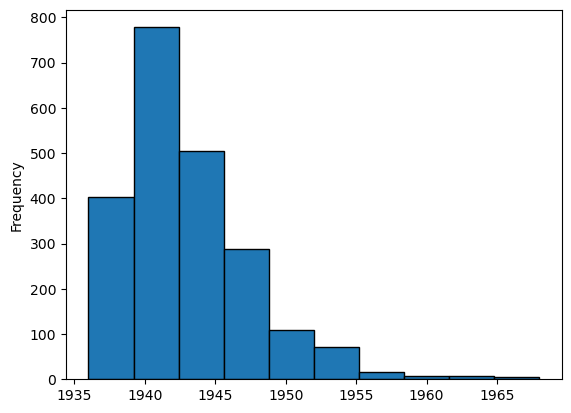

In [6]:
# plot histogram of the birth year
df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')
birth_year_counts_histogram, birth_year_histogram_edges = np.histogram(df["Birth Year"], bins=10)
print(f"Counts {birth_year_counts_histogram}")
print(f"Edges: {birth_year_histogram_edges}")
# describe the birth year
df.describe()

#### Extract samples of patients undiagnosed with vascular dementia with similar birth year

In [7]:
drop_if_na_list = [
    "Alanine aminotransferase",
    "Albumin",
    "Alkaline phosphatase",
    "Apolipoprotein A",
    "Apolipoprotein B",
    "Aspartate aminotransferase",
    "C-reactive protein",
    "Calcium",
    "Cholesterol",
    "Creatinine",
    "Cystatin C",
    "Direct bilirubin",
    "Gamma glutamyltransferase",
    "Glucose",
    "Glycated haemoglobin (HbA1c)",
    "HDL cholesterol",
    "IGF-1",
    "LDL direct",
    "Lipoprotein A",
    "Oestradiol",
    "Phosphate",
    "Rheumatoid factor",
    "SHBG",
    "Testosterone",
    "Total bilirubin",
    "Total protein",
    "Triglycerides",
    "Urate",
    "Urea",
    "Vitamin D",
    
    "Basophil count",
    "Basophil percentage",
    "Eosinophil count",
    "Eosinophil percentage",
    "Haematocrit percentage",
    "Haemoglobin concentration",
    "High light scatter reticulocyte count",
    "High light scatter reticulocyte percentage",
    "Immature reticulocyte fraction",
    "Lymphocyte count",
    "Lymphocyte percentage",
    "Mean corpuscular haemoglobin",
    "Mean corpuscular haemoglobin concentration",
    "Mean corpuscular volume",
    "Mean platelet (thrombocyte) volume",
    "Mean reticulocyte volume",
    "Mean sphered cell volume",
    "Monocyte count",
    "Monocyte percentage",
    "Neutrophil count",
    "Neutrophil percentage",
    "Nucleated red blood cell count",
    "Nucleated red blood cell percentage",
    "Platelet count",
    "Platelet crit",
    "Platelet distribution width",
    "Red blood cell (erythrocyte) count",
    "Red blood cell (erythrocyte) distribution width",
    "Reticulocyte count",
    "Reticulocyte percentage",
    "White blood cell (leukocyte) count",
    "Blood Pressure Diastolic",
    "Blood Pressure Systolic",
    "Pulse Rate at Blood Pressure"
]

In [8]:

# Sample "count" rows from dataframe following a condtion by chunks randomly.
# May sample up to "count" + "samples_per_chunk" rows.
def sample_by_condition(file_path, column, condition_function, count, samples_per_chunk, chunksize=10000):
    result = pd.DataFrame()
    samples_collected = 0

    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        # remove unnecessary columns first.
        chunk = get_columns_from_chunk(chunk, datafields, oldest=True)
        
        mask = condition_function(chunk[column])
        filtered_chunk = chunk.loc[mask]

        filtered_chunk = filtered_chunk.dropna(subset=drop_if_na_list) # drop if missing value for some columns
        
        if filtered_chunk.empty:
            continue
    
        remaining_samples = count - samples_collected
        if remaining_samples <= 0:
            break
    
        k = min(samples_per_chunk, len(filtered_chunk))
        
        chunk_sample = filtered_chunk.sample(n=k)
    
        if result.empty:
            result = chunk_sample
        else:
            result = pd.concat([result, chunk_sample], ignore_index=True, copy=False)

        samples_collected += len(chunk_sample)

        if samples_collected >= count:
            break
    
    return result.sample(n=count) # quick way to make sure exactly "count" rows is returned

In [ ]:
def birth_year_condition(series):
    return (series >= 1936) & (series <= 1968)

per_chunk = 400
col_name = "Birth Year"
vd_1 = "Vascular Dementia Date First Reported"
vd_2 = "Date of vascular dementia report"

undiagnosed_df = pd.DataFrame()

for i in range(len(birth_year_counts_histogram)):
    start, end = birth_year_histogram_edges[i], birth_year_histogram_edges[i+1]
    count = birth_year_counts_histogram[i]
    
    df = sample_by_condition(UKBB_PATH, col_name, lambda x:(x >= start) & (x <= end), count, per_chunk)
    
    df = df[df[vd_1].isna() & df[vd_2].isna()] # drop if has vascular dementia
    
    df = convert_date_to_binary(df, DateReportedFields)
    
    undiagnosed_df = pd.concat([undiagnosed_df, df], ignore_index=True)

# drop vascular dementia columns, and assign new with 0 (undiagnosed)
undiagnosed_df.drop(columns=[vd_1, vd_2])
undiagnosed_df["Has Vascular Dementia"] = 0

undiagnosed_df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')

undiagnosed_df.describe()

In [ ]:
undiagnosed_df.to_csv("randomly_sampling_by_birth_year.csv")

### Save the extracted dataset

In [ ]:
#df.to_csv('vascular_dementia_filtered_2.csv')

#df.head(10)